# Transfer Learning et Clustering d'Images : Hackathon BRGM & EY 2018

In [160]:
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import random
import cv2
import glob
import keras
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pandas as pd
import tensorflow as tf

## Sources : 
- https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb?fbclid=IwAR0NNOMFhqyY0TBz_C1Izwd3LRYEZTwm6FZC7y45E48OdP74z4J86f5Mbw
- Notebook:  `baseline_images_keras.ipynb`


In [161]:
# Affiche les gpus disponibles pour le calcul 

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [114]:
# A retenir: La premiere personne d'un port qui lance une session de calcul sur keras ou tensor (keras=tensor) va 
# s'accaparer le gpu. 
# La bonne manière pour ne pas se voler la gpu disponible est de rendre les gpu dispos invisibles:

#import os
#os.environ[“CUDA_VISIBLE_DEVICES”]=“” 

In [163]:
# Utilise flow from directory pour charger un gros volume d'image par minibatch de 250 
# Ajout d'une option pour les recadrer en 224*224 et no shuffle
from keras . preprocessing . image import ImageDataGenerator

train_datagen = ImageDataGenerator (rescale=1./ 255) 
test_datagen = ImageDataGenerator (rescale=1./ 255)
train_generator= train_datagen.flow_from_directory(   #Shuffle=False 
    '/Users/williamlambert/Desktop/DATA_HACKATHON/' ,
    target_size= (224, 224),
    batch_size= 250,
shuffle=False)

Found 34729 images belonging to 4 classes.


In [165]:
#Affiche la taille d'un batch chargé précédemment : la 4eme dimension correspond aux trois couches RVB
i=0
for batch in train_generator:
    print(batch[0].shape)
    break

(250, 224, 224, 3)


## Training du Resnet50, VGG16 : très long sur CPU !  (à distribuer sur une GPU)

In [10]:
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
vgg16_model = vgg16.VGG16(weights='imagenet',input_shape=(224,224,3))
resnet50_model = resnet50.ResNet50(weights='imagenet',input_shape=(224,224,3))

In [ ]:
# On a récupéré la couche située juste avant la couche dense avg_pool
resnet_model.summary()

In [ ]:
# On a récupéré la couche située juste avant la couche dense avg_pool
vgg16_model.summary()

## RESNET

In [ ]:
# On récupère les couches inférieures d'un réseau de neurones convolutif pré-entrainé 
import time
logits=[]
i=0

liste_names = []
from keras.models import Model
for batch in train_generator:
    if i>136:
        break
    
    print(i,flush=True)
    time.sleep(1) 
    intermediate_layer_model = Model(inputs=resnet50_model.input,
                                 outputs=resnet50_model.layers[-3].output)
    intermediate_output = intermediate_layer_model.predict(batch[0])
    logits.append(intermediate_output)
    i+=1
    idx = (train_generator.batch_index - 1) * train_generator.batch_size
    liste_names.append(train_generator.filenames[idx : idx + train_generator.batch_size])

# On affiche la progression des batchs (chaque batch contient 250 images)
# On récupère nos features de sortie (logits) de taille (batch_size,1,1,2048)
# Important : On sauvegarde l'ordre des images appelés par ImageDataGenerator dans une liste pour retrouver l'image
# qui correspondra à un cluster

#On transforme notre liste_names qui est de taille (n_batch,batch_size) en list_name de taille (n_images) 
list_name=[]
for j in range(len(liste_names)):
    for item in liste_names[j][:]:
        list_name.append(item)
        
#On empile tous nos logits de sortie dans une np.Array de taille (nimages,1,1,2048)
array_img_out=np.array(logits[0])
for i in range (len(logits)-1):
    array_img_out=np.r_[array_img_out,logits[i+1]]

#On aplatit la matrice en np.array (nimages,2048) pour lancer les algos PCA et Clustering
flat=array_img_out.reshape(array_img_out.shape[0],-1)

## VGG16

In [ ]:
import time
logits=[]
i=0

liste_names = []
from keras.models import Model
for batch in train_generator:
    if i>136:
        break
    
    print(i,flush=True)
    time.sleep(1) 
    intermediate_layer_model = Model(inputs=vgg16_model.input,
                                 outputs=vgg16_model.layers[-3].output)
    intermediate_output = intermediate_layer_model.predict(batch[0])
    logits.append(intermediate_output)
    i+=1
    idx = (train_generator.batch_index - 1) * train_generator.batch_size
    liste_names.append(train_generator.filenames[idx : idx + train_generator.batch_size])

# On affiche la progression des batchs (chaque batch contient 250 images)
# On récupère nos features de sortie (logits) de taille (batch_size,1,1,2048)
# Important : On sauvegarde l'ordre des images appelés par ImageDataGenerator dans une liste pour retrouver l'image
# qui correspondra à un cluster

#On transforme notre liste_names qui est de taille (n_batch,batch_size) en list_name de taille (n_images) 
list_name=[]
for j in range(len(liste_names)):
    for item in liste_names[j][:]:
        list_name.append(item)

In [12]:
#On teste si tout s'est bien passé et si le format de nos données de sortie est bien (n_images*2048)

In [23]:
flat.shape

(34250, 2048)

# PCA pour la réduction de dimension 

In [199]:
def create_fit_PCA(data, n_components=None):
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    return p

In [200]:
resnet50_pca = create_fit_PCA(flat,35)

In [201]:
# Fonction pour plot la cumulative explained variance expliquée en fonction du nombre de composantes principales
#Permet de choisir le nombre de composantes à retenir
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

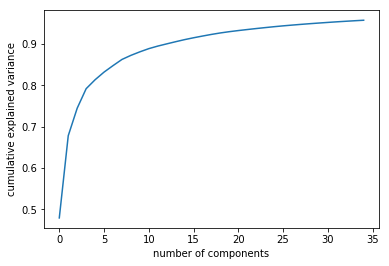

In [202]:
pca_cumsum_plot(resnet50_pca)

In [203]:
resnet50_output_pca = resnet50_pca.transform(flat)

In [204]:
resnet50_output_pca.shape

(34250, 35)

# Clustering Time avec kmeans

In [205]:
n_comp=30

In [206]:
from sklearn.cluster import MiniBatchKMeans

def create_train_kmeans(data, number_of_clusters=n_comp):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = MiniBatchKMeans(n_clusters=number_of_clusters, random_state=728, batch_size=250)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [207]:
print("\nResNet50:")

K_resnet50_pca = create_train_kmeans(resnet50_output_pca) #Train


ResNet50:
Training took 0.2083730697631836 seconds


In [208]:
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca) #Predict

In [209]:
#Affiche un sample des prédictions obtenues
k_resnet50_pred_pca[0:20]

array([27, 12,  8,  4,  3, 27, 27,  7, 24, 19,  8,  3, 24, 16,  1,  7,  7,
        8, 27, 27], dtype=int32)

In [210]:
k_resnet50_pred_pca.shape

(34250,)

In [211]:
#Récupère toutes les images appartenant à chaque cluster dans un dictionnaire

dic={}
for pos,cluster in enumerate(k_resnet50_pred_pca):
    dic[cluster]=dic.get(cluster,[])+[pos]
                        

    



## Pour plotter les images de chaque cluster proprement 

* ###  Resizing de toutes les images 224 x 224

In [264]:
def resize_img(image,width,height):
    array_image = np.array(image) #convertir la photo en matrice
    image_ = np.zeros((width, height, 3))  # une image
    x_win = max(array_image.shape[0]//width, 1)  #max longueur//224 et 1
    y_win = max(array_image.shape[1]//height, 1) # max largeur//224 et 1
    for x in range(width):
        for y in range(height):
            for z in range(3):
                if x*x_win < array_image.shape[0] and y*y_win < array_image.shape[1]:
                    image_[x, y, z] = int(np.max(array_image[x*x_win: (x+1)*x_win, y*y_win: (y+1)*y_win, z]))
                
    return image_

def plot_images_cluster(k,dico,img_per_row=5,row=5,size_x=150,size_y=200,folder_path='/Users/williamlambert/Desktop/DATA_HACKATHON/'):
    #Takes a dictionnary with for each clusters each indexes of images belonging to these cluster
    #You must have a list of all the path of images corresponding to dictionnary indexes
    
    
    name_list=[]
    pos_sample=dico[k]
    for i in pos_sample:
        name_list.append(list_name[i])
        
        
    empty=5 
    
    space_btw_row=255 * np.ones((empty,img_per_row*(size_y + empty),3))
    space_btw_img=255*np.ones((size_x,empty,3))
    plot_final=[]
    
    
    for i in range(row):
        row_list=[]
        for image in name_list[ img_per_row*i : img_per_row*(i+1)] :

            img=Image.open(folder_path+image)  #folder path here
            img=resize_img(img,size_x,size_y)
            img=np.concatenate((img,space_btw_img),axis=1)
            row_list.append(img)
        
        
        row_array=np.concatenate( (np.concatenate(row_list,axis=1) , space_btw_row ), axis=0)
        plot_final.append(row_array)
    print("plot_final_shape=")
    np.array(plot_final).shape
    plot_final_array=np.concatenate(plot_final,axis=0)
    plt.figure(figsize=(20,60))
    plt.imshow(plot_final_array.astype('int'))
    plt.axis("off")
    plt.show()
 
    return plot_final_array




## Exemple de mauvais clusters à retirer des données

plot_final_shape=


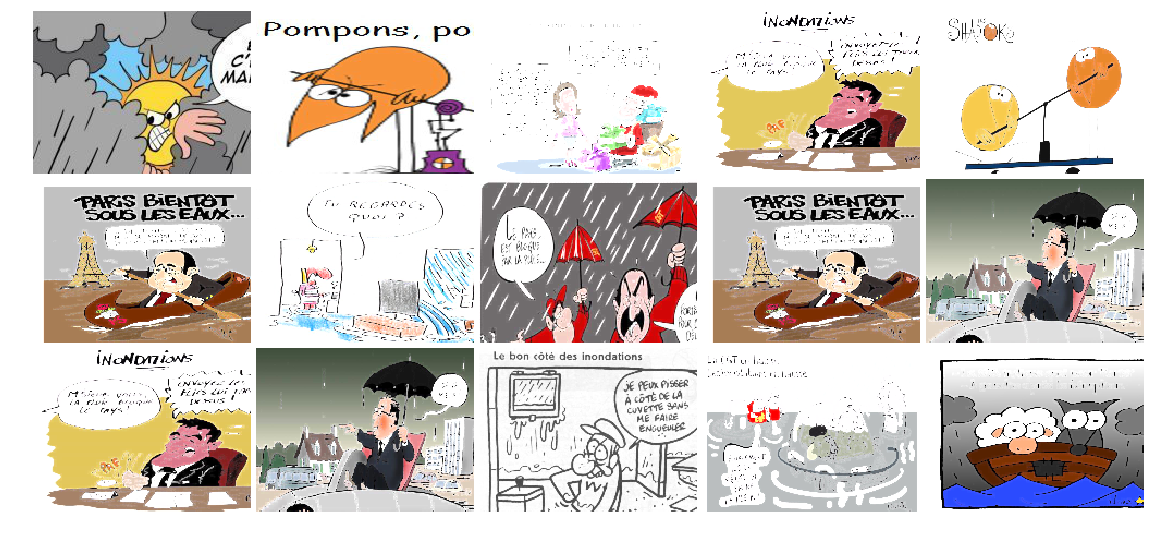

In [308]:
Array=plot_images_cluster(6,dic,row=3)

plot_final_shape=


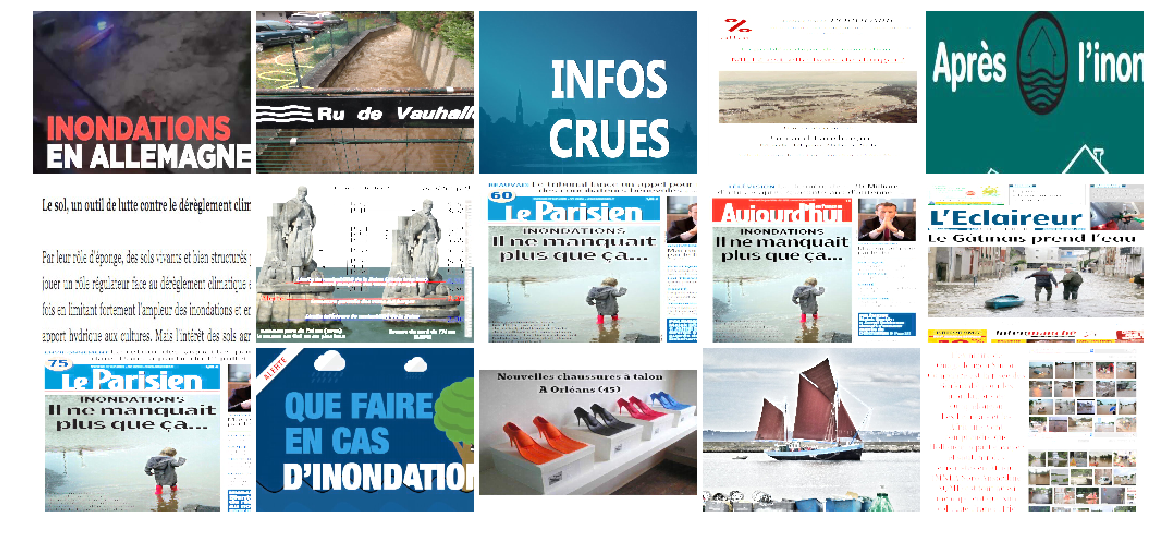

In [309]:
Array=plot_images_cluster(10,dic,row=3)

plot_final_shape=


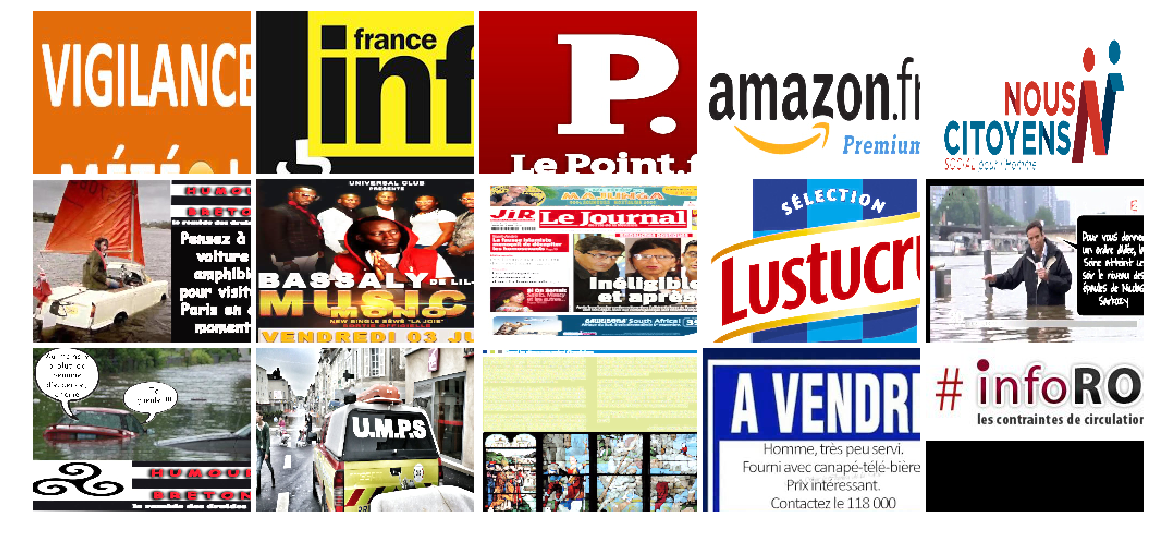

In [326]:
Array=plot_images_cluster(0,dic,row=3)

## Exemples de bons clusters à préserver 

plot_final_shape=


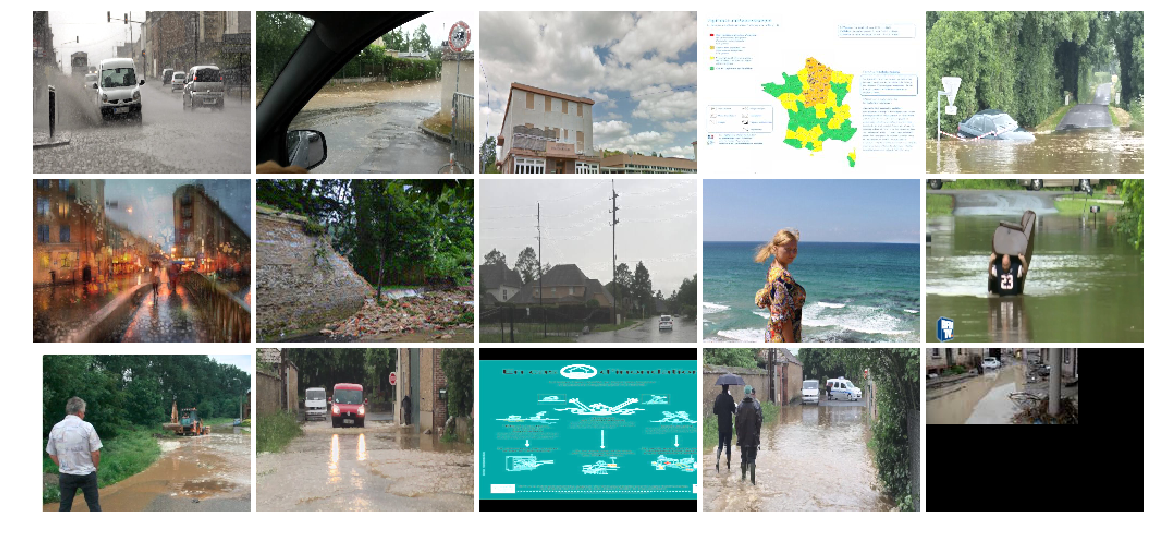

In [319]:
Array=plot_images_cluster(8,dic,row=3)

plot_final_shape=


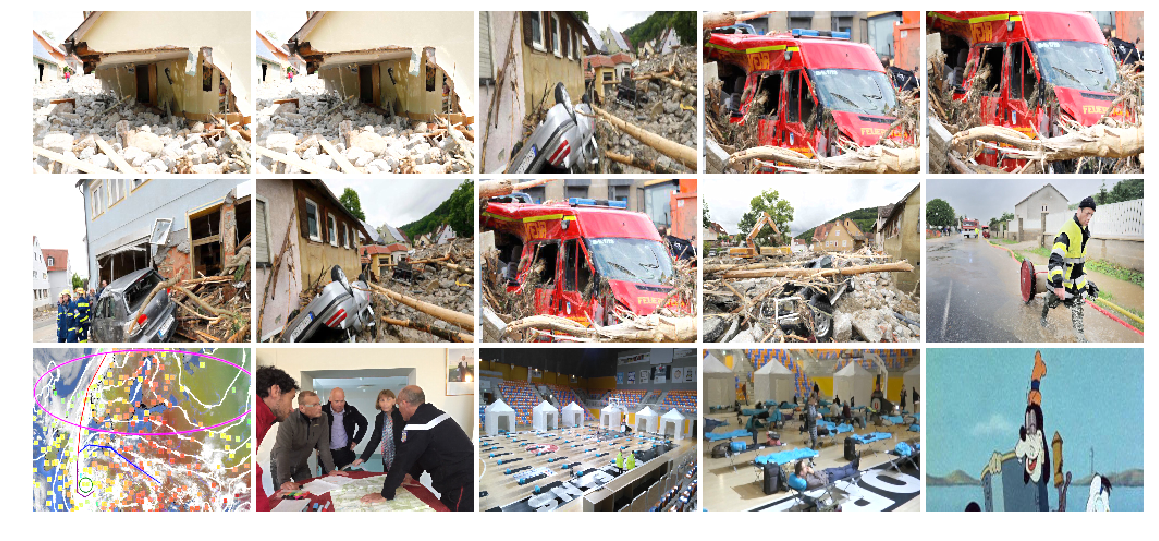

In [318]:
Array=plot_images_cluster(2,dic,row=3)